# Chapter 14 | Convolutional Neural Networks (CNNs)
They emerged from the study of the brain's visual cortex and they represent the state of art in image recognition, but they are also implemented in other tasks, such as voice recognition and natural language processing.

## The Visual Cortex
One of the main insights drawn from past experiments is that many neurons in the visual cortex have **small local receptive field**, so they react only to visual stimuli located in a limited region. The overlap of the receptive fields of different neurons take to the whole visual field.

Moreover, some neurons react only to images of horizontal lines, some only to **different orientation** ones, even if they share the same receptive field.

Furthermore, some neurons have larger receptive fields and they react to more complex patterns, that are combinations of the lower-level patterns: this took to the idea that higher-level neurons are based on the outputs of neighboring lower-level neurons.

These discoveries inspires the neocognitron, which gradually evolved into the nowadays **Convolutional Neural Networks (CNNs)**; these introduces 2 new building blocks:
- **Convolutional Layers**;
- **Pooling Layers**.

## Convolutional Layers

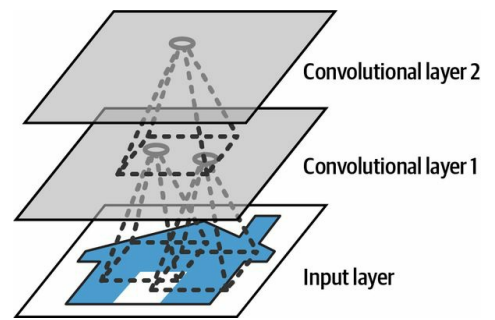

It is the most important block of CNNs; the main difference with a Fully Connected Layer is that neurons in the first convolutional layer are **not connected** to every single pixel in the input image, but only to pixels in their **receptive fields** (in a fully connected layer with input of 100x100 pixels = 10,000 pixels, we would have 10,000 neurons just in the first layer, which need to be connected to each of the neurons of the next layer, taking to lot of connections and weights).

This **locality** allows the network to focus on small low-level features in the first layer, then assemble them into larger higher-level features in the next layer, and so on.

Suppose having a receptive field with dimensions $f_h \times f_w$: a neuron located in row $i$ and column $j$ of a given layer will be connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h-1$ and columns $j$ to $j + f_w -1$. 

Considering those "$-1$" would take to decrease the dimension of data in each layer, it is common to add zeros around the input; this technique is called **zero padding**.

Another technique allowing to connect large input layer to smaller layer is called **stride**, which involve to space out the receptive fields, reducing the computational complexity.

### Filters (or Kernels)
The set of weights big as the size of the receptive fields form the so called **filter (or convolution kernel, or kernel)**.

Based on the weights of this filter, neurons using them will focus on some aspects of their receptive field and ignore others.

For example, if all neurons in a layer use a filter with 1s in central column and 0s anywhere else, this will take to ignore everything in their receptive field except for the central vertical line (Left Image on the figure below), while using a filter with 1s in central row and 0s anywhere else will take to ignore everything except for the central horizontal line (Right Image on the figure below).

The output of one Convolutional Layer is called a **Feature Map**. 

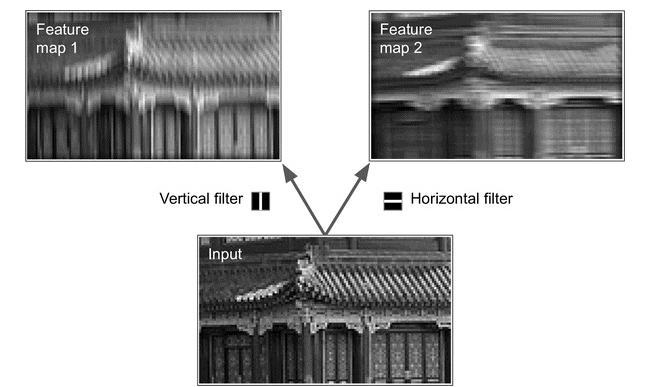

(NOTE: the convolutional layer will **automatically learn** the most useful filters for its task)

### Feature Maps
As we saw above, the output of one Convolutional Layer is called the Feature Map; in the image above we represented it with a 2D layer (i.e., an image), but in reality, a Convolutional Layer will use **multiple filters** (we need to decide how many), so it output several feature maps, one per filter, taking to a 3D layer.

The convolutional layer has **one neuron per pixel in each feature map** and all neurons in a given feature map share the same parameters (i.e., same kernel and bias); neurons in different feature maps use different parameters.

(NOTE: sharing same parameters in one feature map drastically reduces the number of parameters; the idea is that once the CNN has learnt to recognize a pattern in one location, it can recognize it in any other location, while this didn't happen with fully connected NN)

We can express the **output of a neuron in a convolutional layer** as:
$$z_{i,j,k} = b_k + \sum_{u=0}^{f_h -1} \sum_{v=0}^{f_w -1} \sum_{k'=0}^{f'_n -1}x_{i', j', k'} \cdot w_{u,v,k',k}$$
with:
$$i' = i \cdot s_h + u$$ 



$$j' = j \cdot s_w + v$$

where:
- $z_{i,j,k}$ is **output of neuron** located in row $i$, column $j$, feature map $k$ (of layer $l$);
- $b_k$ is **bias term** for feature map $k$ (of layer $l$); think of this as knob tweaking the brightness of the feature map;
- $x_{i', j', k'}$ os **output of neuron** located in row $i'$, column $j'$, feature map $k'$ (of layer $l-1$); if $l-1$ is the input layer, then $k'$ is a channel;
- $w_{u,v,k',k}$ is the **connection weight** between any neuron in feature map $k$ (of the layer $l$) and its input located at row $u$, column $v$, feature map $k'$.

### Implementing Convolutional Layer with Keras
Let's load some sample images:

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height = 70, width = 120)(images) # Resize to Guarantee same Dimensions (70 x 120)
images = tf.keras.layers.Rescaling(scale = 1/255)(images) # Normalization to get all pixels ranging from 0 to 1

Let's look at the shape:

In [2]:
images.shape

TensorShape([2, 70, 120, 3])

(2 sample images, 70x80 pixels, 3 channels)

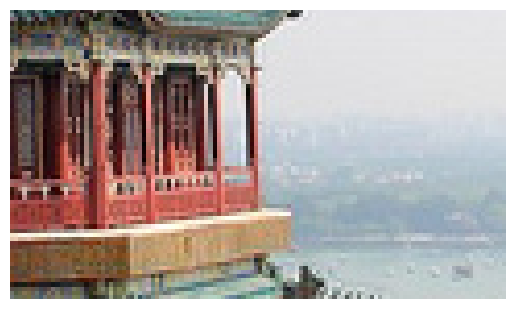

In [3]:
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.axis('off')
plt.show()

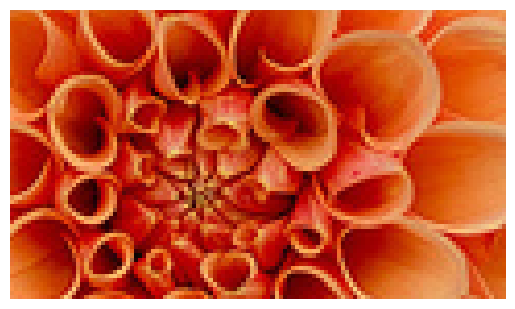

In [4]:
plt.imshow(images[1])
plt.axis('off')
plt.show()

Even if 'images' has 4 dimensions, in reality it has 2 spatial dimensions (height and width); let's implement a 2D Convolutional Layer with 32 Filters, each of size 7x7:

In [5]:
conv_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size = 7)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

We can see 2 main differences:
- both Height and Width shrunk by 6 pixels (this is because we didn't add any 0-padding so we lose pixels on the sides; being the kernel 7x7, we lose 6 pixels horizontally and 6 vertically);
- we went from 3 channels (RGB) to 32 channels (the feature maps): instead of having the intensity of red, green and blue at each location, we now have the intensity of each feature map at each location.

By default, the parameter is *padding = "valid"*, which means no 0-padding (the receptive field of each neuron must lie within *valid* positions, so no out of bound);

if we want 0-padding, we can put the parameter *padding = "same"* (which means that, with stride s = 1, feature maps end up with *same* size as input).

The formula to get the output size is:

$$ o = round\_down(\frac{i +2p -f}{s}) + 1$$

Let's try with 0-padding:

In [6]:
conv_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = 'same')
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

We can access the layer parameter (kernels and biases) in 2 ways:
- as TF variables:

In [7]:
conv_layer.weights

[<Variable path=conv2d_1/kernel, shape=(7, 7, 3, 32), dtype=float32, value=[[[[-5.07788956e-02 -1.81158483e-02 -1.77524500e-02 ...  4.38909829e-02
     -8.70883465e-03 -8.56657326e-03]
    [-2.10216418e-02  5.63775524e-02  1.27772763e-02 ... -1.67805776e-02
     -3.32651660e-03  2.03185901e-03]
    [ 5.27604073e-02  1.65033564e-02 -2.39940956e-02 ... -9.50660184e-03
      6.09412044e-03 -2.31505223e-02]]
 
   [[-4.56591994e-02 -1.28202289e-02  1.80725679e-02 ... -2.68244408e-02
     -2.94505209e-02  1.01848692e-02]
    [-1.88770369e-02  3.04095075e-02  5.42390347e-03 ... -5.47614247e-02
     -2.75014713e-03  3.97446752e-03]
    [ 5.37887067e-02 -4.09809574e-02  2.27448493e-02 ...  3.61806303e-02
     -2.27760971e-02 -3.27292010e-02]]
 
   [[-6.72272220e-03  5.35563752e-02  5.55800125e-02 ...  1.87220424e-02
     -5.00777960e-02 -1.70888342e-02]
    [ 2.79143676e-02  4.71251458e-03 -1.60683654e-02 ...  1.97289884e-03
     -5.41397072e-02  4.86671925e-02]
    [ 9.08359885e-04  8.00450146

- as np arrays:

In [8]:
conv_layer.get_weights()

[array([[[[-5.07788956e-02, -1.81158483e-02, -1.77524500e-02, ...,
            4.38909829e-02, -8.70883465e-03, -8.56657326e-03],
          [-2.10216418e-02,  5.63775524e-02,  1.27772763e-02, ...,
           -1.67805776e-02, -3.32651660e-03,  2.03185901e-03],
          [ 5.27604073e-02,  1.65033564e-02, -2.39940956e-02, ...,
           -9.50660184e-03,  6.09412044e-03, -2.31505223e-02]],
 
         [[-4.56591994e-02, -1.28202289e-02,  1.80725679e-02, ...,
           -2.68244408e-02, -2.94505209e-02,  1.01848692e-02],
          [-1.88770369e-02,  3.04095075e-02,  5.42390347e-03, ...,
           -5.47614247e-02, -2.75014713e-03,  3.97446752e-03],
          [ 5.37887067e-02, -4.09809574e-02,  2.27448493e-02, ...,
            3.61806303e-02, -2.27760971e-02, -3.27292010e-02]],
 
         [[-6.72272220e-03,  5.35563752e-02,  5.55800125e-02, ...,
            1.87220424e-02, -5.00777960e-02, -1.70888342e-02],
          [ 2.79143676e-02,  4.71251458e-03, -1.60683654e-02, ...,
            1.972

In [9]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

(kernel_height, kernel_width, input_channels, output_channels)

In [10]:
biases.shape

(32,)

Lastly, we generally want to specify an Activation Function (such as ReLU), for the same reason as for Dense layers, in which we wanted to add Non-Linearity.

As we see, CNN has quite few hyperparameters:
- number of filters;
- size of filters;
- padding;
- strides;
- activation function;
- initializer of filter;
- ...
  
We can still use cross-validation, but it's very time consuming, so we'll discuss about common CNN architectures to get some working best hyperparameter values.

## Pooling Layer
The goal of the pooling layer is to **subsample (shrink)** the input image in order to reduce computational load, memory usage and number of parameters (reducing risk of overfitting).

Just as in the convolutional layer, each neuron in a pooling layer is just locally connected to a limited number of neurons of the previous layer in its receptive field (so we need to define size, stride, padding), but this time, we don't have any weights: the pooling neurons use an **Aggregation Function** (such as max or mean) to aggregate the inputs.

For example, by using **Max-Pooling** (which is indeed the most common one), only the max input value in each receptive field makes it to the next layer, while the other are dropped:

(Example below is Max-Pooling with a 2x2 Pooling Kernel, stride of 2 and no padding; the stride of 2 makes the output image have half height and width of input image, rounded down since no padding)

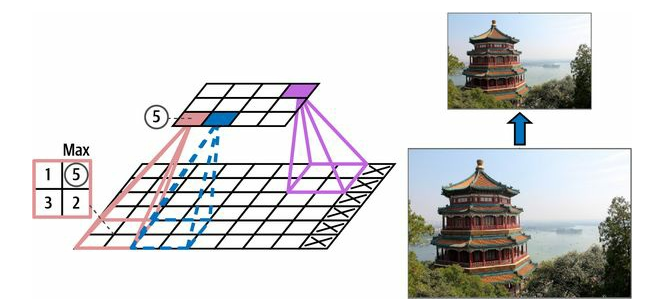

Max-Pooling introduces some level of **invariance to small translations**, which is a good advantage in tasks life classification, but may also be a downside in other tasks like semantic segmentation (the goal here is **equivariance**, not invariance, cause a small change to inputs may lead to a corresponding change in the output): 

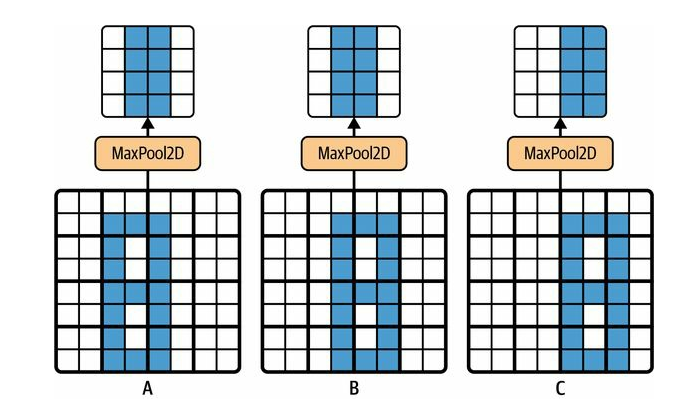

We can sum the downsides of max-pooling by highlighting its **destructive** effect.

### Implementing Pooling Layers with Keras
We will implement a MaxPooling 2D layer with a 2x2 Pooling Kernel:

(NOTE: stride is by default equal to the kernel size, so 2, while padding is by default 'valid', so no padding)

In [11]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

(NOTE: we can implement an Average Polling layer with AvgPool2D, but keep in mind that MaxPooling geberally performs better)

Considering MaxPooling add invariance to feature, by applying pooling along the depth dimension (instead of the spatial dimensions) allows the CNN to learn to be invariant to various features (rotation, thickness, brighthness, skew, color...); still, this practice is not that common.

Other than MaxPooling and AvgPooling, another modern approach is **Global Average Pooling**, which computes the mean of each entire feature map (it is like using AvgPooling with a Pooling Kernel with same size as input), taking to a single number output per feature map (it is extremely destructive, but can be useful just before the output layer):

In [13]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

For example, we can apply this to the input images and get the mean intensity of red, green and blue:

In [14]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

## CNN Architectures
Now that we know all the building blocks, let's look at the whole architecture of a CNN.

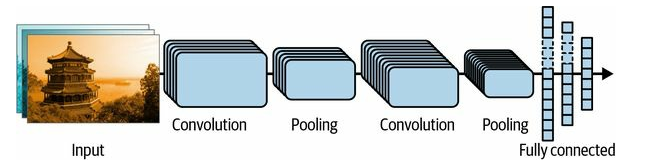


CNNs usually involve:
- Input Layer;
- a series of Convolutional Layers, Activation Function (generally ReLU) and Pooling Layers (generally MaxPooling);
- a Fully Connected NN (compose of fully connected layers with ReLUs and final output layer for predictions, usually softmax).

The more we progress in the "Convolutional part" of the network (Convolutional Layers, ReLU, Pooling), the more the image gets smaller, but deeper (i.e., more feature maps).

(**TIP**: instead of using larger kernel, use more layers with smaller kernels; for example instead of a convolutional layer with 5x5 kernel, use two layers with 3x3 kernels: this will take to fewer parameters, fewer computations and usually better performance; 
**EXCEPTION**: in the first convolutional layer the kernel is typically larger, such as 5x5 with stride of 2, in order to reduce spacial dimension without lossing too much information and with not that much computations, considering at the start we only have 3 channels in general)

## Full CNN Implementation for MNIST Challenge

In [18]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')

model = tf.keras.Sequential([
    DefaultConv2D(filters = 64, kernel_size=7, input_shape = [28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 10, activation = 'softmax')
    ])

(functools.partial() helped us create a Conv2D object but with different default arguments, to avoid rewriting it each time)

The Sequential model has:
- Convolutional Layer with 64 7x7 filters, default stride of 1 (cause images are not that large) and input shape as the MNIST images (28x28 with a single channel);
- Max Pooling Layer with default pool size of 2 (so each spatial dimension is divided by a factor of 2);
- 2 Convolutional Layer + 1 MaxPooling (we repeat this whole structure 2 times);

    (NOTE: for larger images, we could repeat this structure more times; number of times is an hyperparameter we can tune)

    (NOTE: we double the output layer each time, cause with pool size of 2, each spatial dimension is divided by a factor of 2, so we're not worried about the number of parameters to explode)
- Flatten Layer (Fully Connected Layer expects a 1D array of features for each instance)
- Fully Connected Layer with 2 hidden dense layers, 2 dropout layers with dropout rate of 50 % (this reduces overfitting) and 1 dense output layer (output layers has 10 units cause it's a classification task with 10 classes).

(if MNIST dataset images come in different shape, we may need to use np.reshape() or to add a Reshape Layer as first layer) 

In [26]:
from functools import partial

tf.random.set_seed(42)

# Load & preprocess MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = x_train[..., tf.newaxis]   # (60000, 28, 28, 1)
x_test  = x_test[..., tf.newaxis]    # (10000, 28, 28, 1)

# Define model (your architecture)
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal"
)

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# Optional: Early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True
    )
]

# Train
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Quick predictions demo
probs = model.predict(x_test[:5])
preds = tf.argmax(probs, axis=1).numpy()
print("First 5 predictions:", preds)
print("True labels        :", y_test[:5])

# Save model
model.save("mnist_cnn.h5")
print("Model saved to mnist_cnn.h5")


C:\Users\39388\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
844/844 - 54s - 64ms/step - accuracy: 0.5954 - loss: 1.0898 - val_accuracy: 0.9810 - val_loss: 0.0733
Epoch 2/10
844/844 - 53s - 62ms/step - accuracy: 0.9144 - loss: 0.2660 - val_accuracy: 0.9900 - val_loss: 0.0393
Epoch 3/10
844/844 - 53s - 63ms/step - accuracy: 0.9630 - loss: 0.1393 - val_accuracy: 0.9855 - val_loss: 0.0635
Epoch 4/10
844/844 - 53s - 62ms/step - accuracy: 0.9777 - loss: 0.0964 - val_accuracy: 0.9910 - val_loss: 0.0385
Epoch 5/10
844/844 - 53s - 62ms/step - accuracy: 0.9824 - loss: 0.0768 - val_accuracy: 0.9923 - val_loss: 0.0425
Epoch 6/10
844/844 - 53s - 63ms/step - accuracy: 0.9839 - loss: 0.0652 - val_accuracy: 0.9928 - val_loss: 0.0408
Epoch 7/10
844/844 - 52s - 62ms/step - accuracy: 0.9864 - loss: 0.0562 - val_accuracy: 0.9927 - val_loss: 0.0458
Epoch 8/10
844/844 - 53s - 62ms/step - accuracy: 0.9892 - loss: 0.0446 - val_accuracy: 0.9892 - val_loss: 0.0421
Epoch 9/10
844/844 - 53s - 62ms/step - accuracy: 0.9898 - loss: 0.0416 - val_accuracy: 0.9945 - 

First 5 predictions: [7 2 1 0 4]
True labels        : [7 2 1 0 4]
Model saved to mnist_cnn.h5


## Most Famous CNN Architectures

### LeNet-5
The [LeNet-5](https://www.eecis.udel.edu/~shatkay/Course/papers/NetworksAndCNNClasifiersIntroVapnik95.pdf) is the most widely known CNN architecture. Created by Yann LeCun in 1998 and widely used for the MNIST challenge. 

The architecture is:

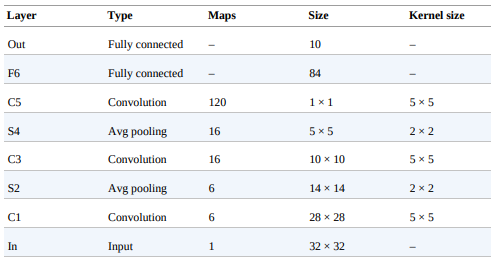

As we see, it is similar to our implementation above: a stack of Convolutional and Pooling Layers, followed by a Dense Network; the main difference is in the activation functions: today, ReLU is preferred to tanh and softmax to RBF (other minor differences don't matter much).

### AlexNet
The [AlexNet](https://papers.nips.cc/paper_files/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) won the 2012 ILSVRC with large margin (top-five error rate of 17%, while the second best achieved 26%). It was developed by Alex Krizhevsky, Ilya Sustkever and Geoffre Hinton. The architecture is very similar to LeNet-5 (just **much larger and deeper**) and it was the first one to **stack Convolutional Layers directly** on top of one another (instead of stacking a Pooling Layer on top of each Convolutional one):

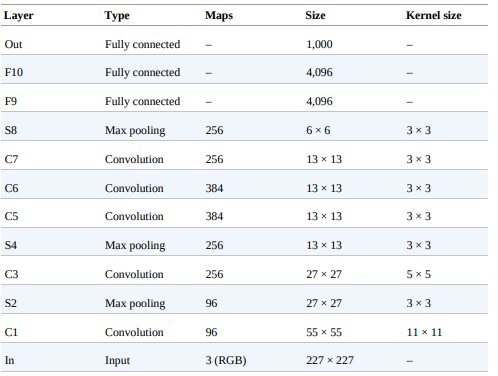

Considering the large amount of parameters, to reduce overfitting the authors used 2 **Regularization Techniques**:
- **Drop-Out** (Chapter 11 of this book) with 50% dropout rate during training to the outputs of layers F9 and F10;
- **Data Augmentation** by randomly shifting the training images (flipping, changing lightning...)

#### Data Augmentation
It is a **Regularization Technique (i.e., reduces overfitting)** used to **artificially increase size of training set** by generating **realistic variants** of each training istance (note how realistic means that humans should not be able to tell wheter the image was augmented or not), in order to increase tolerance to particular conditions of the picture. It can be used also to generate more samples of the **less frequent class** (in this case the technique is called **Syntethic Minority Oversampling Technique (SMOTE)**).

Examples of Data Augmentation are **shifting, rotating, resizing** the pictures (these techniques forces the model to be **more tolerant** to **variations in position**). This can be done in Keras with the **Keras's Data Augmentation Layers** (already introduced in Chapter 13 of this book), such as **RandomCrop, RandomRotation, etc.** 
Other examples rely on forcing the model to be **more tolerant** to **different lighting conditions**, by simply changing the images contrasts.

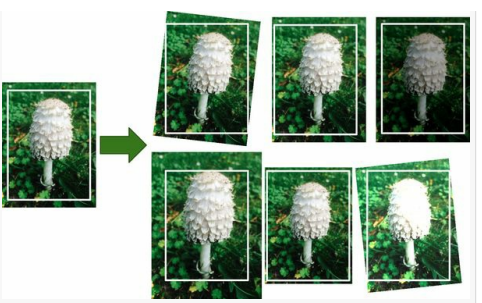

Another technique used in AlexNet is the so called **Local Response Normalization (LRN)**, a **Competitive Activation** step in which the **most strongly activated neurons** inhibit other neurons located at the same position in neighboring feature maps, incouraging different feature maps to **specialize**, pushing them apart and **forcing them to explore wider range of features**, **improving generalization** (this type of competitive activation has been observed in biological neurons and it is called **Lateral Inhibition**).

We can perform LRN with the equation:

$$b_i = \frac{a_i}{(k + \alpha \sum_{j = j_{low}}^{j_{high}}a_j^2)^\beta}$$

with:
- $j_{low} = max(0, i - \frac{r}{2})$;
- $j_{high} = min(i + \frac{r}{2}, f_n -1)$

where:
- $b_i$ is the **Normalized Output** of neuron located in feature map $i$, at some row $u$ and column $v$ (in this equation, we only consider neurons located at this row and column, so $u$ and $v$ are omitted);
- $a_i$ is the **Activation** of that neuron after ReLU step (just before Normalization);
- $k, \alpha, \beta, r$ are **hyperparameters** of the RLN ($k$ is called **bias**, $r$ is called **depth radius**);
- $f_n$ is **number of feature maps**.

For example, suppose to put $r = 2$ and to have a neuron with strong activation: it will inhibit the activation of the neurons located in the feature maps immediately above and immediately below its own feature map.

In AlexNet, $r = 5, \alpha = 0.0001, \beta = 0.75, k = 2$.

We can implement this step by using the tf.nn.local_response_normalization() method, which can be wrapped in a Lambda layer to be used in a Keras model.

[ZF Net](https://arxiv.org/abs/1311.2901), which won the 2013 ILSVRC, is essentialy AlexNet with few different hyperparameters.


### GoogLeNet
The [GoogLeNet](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Szegedy_Going_Deeper_With_2015_CVPR_paper.html), developed by Christian Szegedy won the ILSVRC 2014, pushing the top-five error rate below 7%. This was reached primarily thanks to a much deeper network than previous, made possible by **subnetworks** called **inception modules**, which allow a much more efficient use of parameters (GoogLeNet has 10 times fewer parameters than AlexNet -> 6 million vs 60 million).

Let's look more in depth an **Inception Module**:

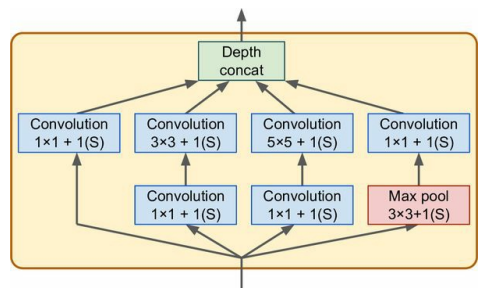

(The notation "$3\times3+1(S)$" means the layer used a $3\times3$ kernel, stride 1 and "same" (S) padding)

Note how:
- the input is fed to four different layers in parallel;
- the top convolutional layers use different kernel sizes (this allow to capture patterns at different scales);
- all layers use stride of 1 and "same" padding, allowing to get outputs with **same height and width** of the inputs, in order to be able to **concatenate all outputs** along the **depth dimension** in the final **Depth Concatenation Layer** (i.e., to stack the feature maps from all 4 layers). This last layer can be  implemented in Keras using Kera's **Concatenate Layer**, using the default "axis = 1".

Why the $1\times1$ kernels?

Altough they cannot capture spatial patterns, they can capture patterns **along the depth dimension** (i.e., across channels); moreover, they output fewer feature maps than their inputs, serving as **bottleneck layers** (i.e., they reduce dimensionality, cutting computational cost, number of parameters, time to train and generalization).

So, the idea of the Inception Module is a "convolutional layer on steroids", which combines 2 convolutional layers with different dimensions, acting like a single powerful convolutional layer (while convolutional layers is equivalent to sweep a dense layer across the image, inception module is equivalent to sweep 2-layer neural networks across the image).

GoogLeNet full architecture:

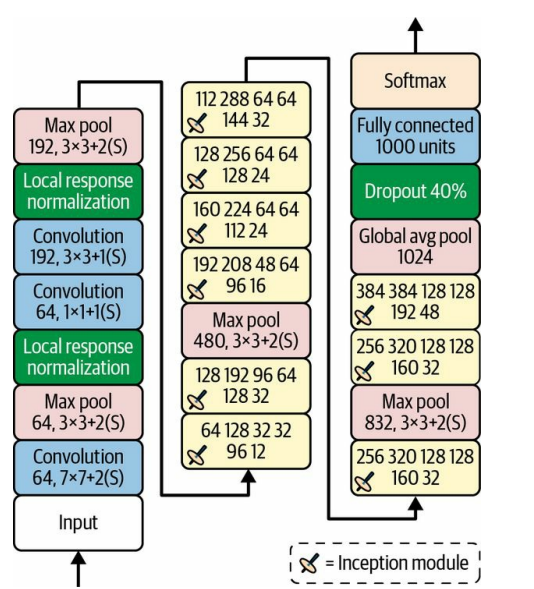

- Convolutional Layer + Max Pooling divide image's height and width by 4 (so its area is divided by 16), reducing computational load. A large $7\times7$ kernel is used at the begininng, preserving much of the information;
- LRN to increase variety of patterns captured by previous layers;
- 2 Convolutional Layers with first acting as Bottleneck Layer;
- LRN to increase variety of patterns captured by previous layers;
- Max Pooling to reduce height and width by 2, reducing computational load;
- 9 Inception Modules (with some Max Pooling layers to reduce computational load);
- Global Average Pooling to output mean of each feature map (this drops any remaining spatial information, which at this point is not that much; moreover, being this a classification task and not a localization one, this dimensionality reduction brought by this layer won't remove any important information and will instead decrease the number of needed fully connected layers at the top of CNN, reducing the number of parameters and overfitting risk);
- last layers are self-explanatory: droput for regolarization, fully connected layer with 1000 units (there are 1000 classes), softmax to get probabilities.

(Inception-v3 and Inception-v4 are variants of GoogLeNet)

### VGGNet
The [VGGNet](https://arxiv.org/abs/1409.1556), developed by Simonyan and Zisserman, classified 2nd in the ILSVRC 2014 with a very **simple and classical** architecture: 2 or convolutional layers and a pooling layer, repeated a series of times, plus a final 2 hidden layers dense network; it used a lot of small $3\times3$ kernels.

### ResNet (Residual Network)
The [ResNet](https://arxiv.org/abs/1512.03385) won the ISLVRC 2015 with a top-five error rate under 3.6%. It used an **extremely deep CNN** (152 layers), confirming the trend of Computer Vision models to become deeper and deeper with fewer and fewer parameters. 

This network was trained using the so called **Residual Learning**: generally, training a NN means to model a target function $h(x)$; with Residual Learning, the goal becomes to model $f(x) = h(x) - x$. This step of adding the input of a layer to the output of a layer located higher up the stack is called **Skip Connection** (also called **Shortcut Connection**).

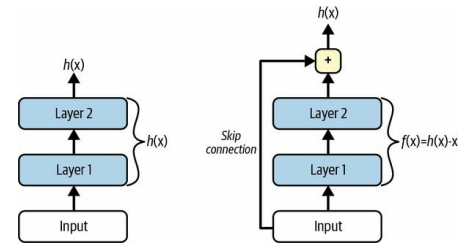

The idea behind this technique is that while a regular NN